In [1]:
%matplotlib inline
%load_ext nb_black
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pdb import set_trace

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


with open("xieyang_neurondata.pkl", "rb") as f:
    pkl = pickle.load(f)

df = pd.read_csv("xieyang_behaviordata.csv")

<IPython.core.display.Javascript object>

#### CPD

In [6]:
def _CPD(X, y):  # 这里的X的shape是273*6，y的shape是273*1800
    """Evaluate coefficient of partial determination for each predictor in X"""
    ols = LinearRegression()  # 建立一个linear regression的拟合object
    #     set_trace()
    ols.fit(X, y)  # 拟合X和y
    sse = np.sum(
        (ols.predict(X) - y) ** 2, axis=0
    )  # 用X预测y，然后和真实的y做残差平方和，sse的shape是1800*1
    cpd = np.zeros([y.shape[1], X.shape[1]])  # 建立一个空的matrix，等等要存储结果，shape是1800*6
    for i in range(X.shape[1]):  # i的loop从0-5，一共6个数
        X_i = np.delete(X, i, axis=1)  # 这里X_i表示"X这个矩阵去掉第i列",所以X_i的shape永远是273*5
        ols.fit(X_i, y)  # 用去掉一列的X_i和y进行拟合
        sse_X_i = np.sum(
            (ols.predict(X_i) - y) ** 2, axis=0
        )  # 用X_i预测y，然后和真实的y做残差平方和，sse_X_i的shape是1800*1
        cpd[:, i] = (
            sse_X_i - sse
        ) / sse_X_i  # 算两种残差的差异，用比例的方式表达，同时把结果存储到cpd这个matrix里面（放到第i列里面）
    return cpd

<IPython.core.display.Javascript object>

In [7]:
cpd1_all = {}
cpd2_all = {}
for i in pkl:
    file_name, indexes = i["file"], i["trial_selected"]
    indexes = indexes[0].astype(int) - 1  # matlab index to python index
    X = (
        df[
            df.file.apply(lambda x: "_".join(x.split("_")[:2]))
            == "_".join(file_name.split("_")[:2])
        ]
        .iloc[indexes, :][["rwd_fed", "c_cue"]]
        .rename(columns={"rwd_fed": "reward", "c_cue": "choice"})
        .replace({-1: 0})
    )
    X["reward_choice"] = X["reward"] * X["choice"]
    cpd1_session = []
    cpd2_session = []
    for n in range(i["Fd1"].shape[-1]):
        if i["Fd1"].shape[0] != X.shape[0]:
            y_Fd1 = i["Fd1"][indexes][:, :, n]
        else:
            y_Fd1 = i["Fd1"][:, :, n]
        if i["Fd2"].shape[0] != X.shape[0]:
            y_Fd2 = i["Fd2"][indexes][:, :, n]
        else:
            y_Fd2 = i["Fd2"][:, :, n]
        cpd1_session.append(_CPD(X.values, y_Fd1))
        cpd2_session.append(_CPD(X.values, y_Fd2))
    cpd1_all[file_name] = np.array(cpd1_session)
    cpd2_all[file_name] = np.array(cpd2_session)

<IPython.core.display.Javascript object>

In [8]:
cpd1 = list(cpd1_all.values())
cpd1 = np.nanmean(np.concatenate(cpd1, 0), axis=0)

cpd2 = list(cpd2_all.values())
cpd2 = np.nanmean(np.concatenate(cpd2, 0), axis=0)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'CPD2')

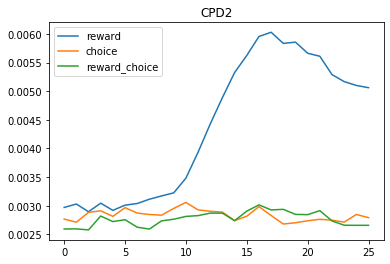

<IPython.core.display.Javascript object>

In [10]:
plt.plot(cpd2)
plt.legend(X.columns)
plt.title("CPD2")

#### PCA

In [97]:
all_type_avgs = []
for i in pkl:
    file_name, indexes = i["file"], i["trial_selected"]
    indexes = indexes[0].astype(int) - 1  # matlab index to python index
    X_choice = (
        df[
            df.file.apply(lambda x: "_".join(x.split("_")[:2]))
            == "_".join(file_name.split("_")[:2])
        ]
        .iloc[indexes, :][["rwd_fed", "c_cue"]]
        .rename(columns={"rwd_fed": "reward", "c_cue": "choice"})
        .replace({-1: 0})
    )
    """masks为四种type的bool mask"""
    masks = (
        X_choice.reset_index()
        .groupby(["reward", "choice"])
        .apply(lambda x: list(x.index))
        .values
    )
    """根据每一种type，在trial的维度上（维度0）上average，同时concatenate"""
    type_avgs = np.concatenate(
        [np.mean(i["Fd2"][m, ::], 0, keepdims=True) for m in masks], 0
    )  # n_type * n_timepoints * n_neurons
    all_type_avgs.append(type_avgs)

combine_neuron_avgs = np.concatenate(
    all_type_avgs, 2
)  # n_type * n_timepoints * all n_neurons
combine_neuron_avgs = combine_neuron_avgs - np.mean(
    combine_neuron_avgs, 0
)  # n_type * n_timepoints * all n_neurons
combine_neuron_avgs = combine_neuron_avgs.swapaxes(
    2, 1
)  # n_type * all n_neurons * n_timepoints
X = np.hstack(
    [caa for caa in combine_neuron_avgs]
)  # [all n_neurons, n_timepoints * n_type]

pca = PCA(n_components=12)
pca.fit(X.T)

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>

/home/tyang/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


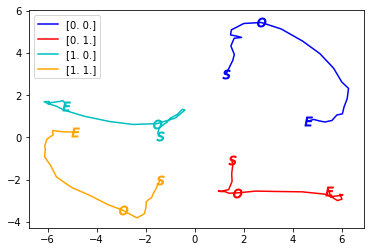

<IPython.core.display.Javascript object>

In [104]:
colors = ["b", "r", "c", "orange"]
for i, caa in enumerate(combine_neuron_avgs):
    # 3D plot
    traj_x = caa.T @ pca.components_[0, :]
    traj_y = caa.T @ pca.components_[1, :]
    plt.plot(traj_x, traj_y, color=colors[i])
    for j, sn, m in zip(range(3), [0, 10, 25], ["$S$", "$O$", "$E$"]):
        plt.scatter(traj_x[sn], traj_y[sn], color=colors[i], marker=m, s=80)
plt.legend(
    (
        X_choice.reset_index()
        .groupby(["reward", "choice"])
        .apply(lambda x: list(x.index))
        .reset_index()
    )[["reward", "choice"]].values
)